# Analisis de incertidumbre

Notebook para analizar algoritmos cuando se tiene incertidumbre en el tiempo de partida.

En primer lugar definimos el algoritmo a estudiar (por ahora EDF o LLF)

In [20]:
Algorithm = "EDF";

In [2]:
#using Pkg;Pkg.instantiate()
#import Pkg; Pkg.add("CSV")
using EVQueues, Plots, Distributions, DataFrames, LaTeXStrings, KernelEstimator, CSV

Se definen los parámetros para realizar las simulaciones

In [3]:
lambda=30.0;
mu=0.5;
gamma=0.25;
C=40.0;
Tfinal=200;

#Incertidumbre (se modela como una Uniforme)
theta=0.5;

C=30.0;

#Parámetros del resto de la simulación
df=CSV.read("df_google.csv", DataFrame);

df.arribos=df.arribos*1.0;
df.salidas=df.salidas*1.0;
df.demandas=df.demandas*1.0;
df.potencias=df.potencias*7.0;

avg_sojourn=mean(df.salidas.-df.arribos)
avg_demand=mean(df.demandas)
avg_service_time=mean(df.demandas./df.potencias)

#filter!(row->row.arribos<120,df);

In [ ]:
time=alg_uncertain.timetrace.T;
n_EVs=P=alg_uncertain.timetrace.X;
power=alg_uncertain.timetrace.P;

In [ ]:
percentage=sum(x->x.==C, power) /length(time)*100

In [4]:
function threshold(theta,lambda,mu,C)
    rho = lambda/mu
    return -1/mu*log( mu*theta*(1-C/rho)/sinh(mu*theta))
end

threshold (generic function with 1 method)

In [5]:
#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edf_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

Simulando... 100%|██████████████████████████████████████| Time: 0:00:01


El siguiente cuadro analiza resultados de vehiculos individualmente

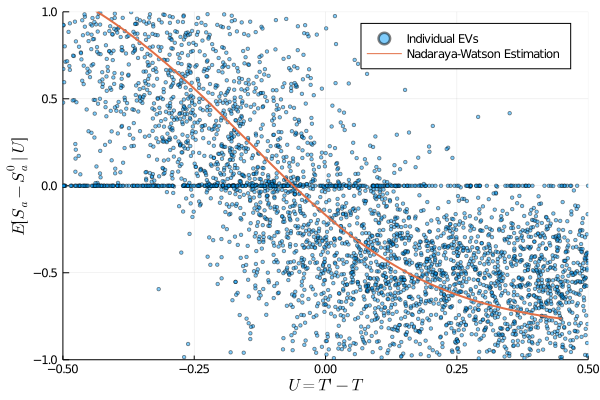

In [6]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;

tau = threshold(theta,lambda,mu,C)

Sa2_teo = (1.0 .-exp.(-mu*max.(-u.+tau,0)))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_alg, xeval=u);

scatter(diff_departure,Sa_alg_uncertain-Sa_alg,alpha=0.5, label="Individual EVs", ms=2, ylims=(-1,1), xlims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson Estimation", ylims=(-1,1), xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#plot!(u,Sa2_teo.-Sa_teo,lw=2, label="Theory", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#savefig("Real traces LLF 1.pdf")

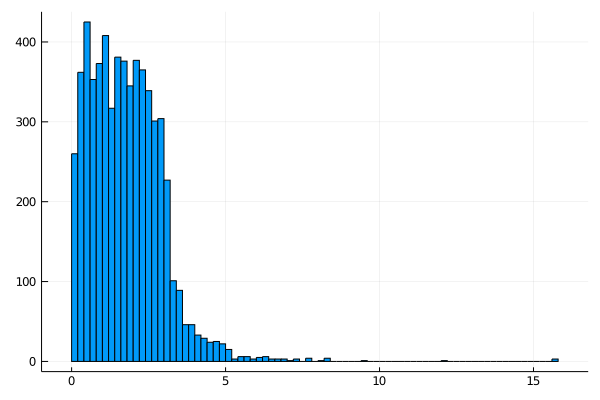

In [26]:
service_time=df.demandas./df.potencias;
histogram(service_time, legend=false)

In [7]:
function llfc_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        deadlines = [ev.currentReportedDeadline for ev in evs];
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];

        positivas = findall(deadlines.>0)
        negativas = findall(deadlines.<=0)
        
        perm1 = sortperm(laxities[positivas]);
        perm2 = sortperm(laxities[negativas], rev=true);
        
        perm = [positivas[perm1];negativas[perm2]]
           
        p=0.0;
        i=1;
        U=zeros(length(evs));

        #recorro el vector en orden de deadline y le asigno su potencia maxima o lo que falte pare llegar a C (puede ser 0)
        while p<C && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C-p);
            p=p+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end

    end
    return U;
end

llfc_policy (generic function with 1 method)

Analisis con curtail

In [21]:
#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edfc_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_sim_trace(df,llfc_policy,C,[Inf]);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edfc_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_sim_trace(df2,llfc_policy,C,[Inf]);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

In [10]:
function threshold2(theta,lambda,mu,C)
    rho = lambda/mu
    ktheta = (1/2 + (exp(mu*theta)-1)/(2*mu*theta))
    return -1/mu*log( (1-C/rho)/ktheta)
end

threshold2 (generic function with 1 method)

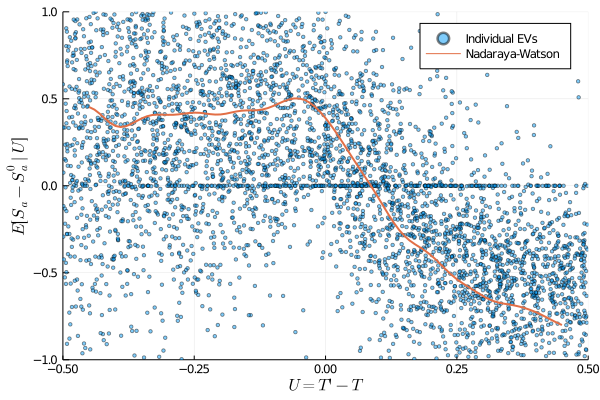

In [22]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;


tau2 = threshold2(theta,lambda,mu,C)
Sa3_teo = (1.0 .-exp.(-mu*max.(-u.*(u.>0).+tau2,0)))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_alg, xeval=u);

scatter(diff_departure,Sa_alg_uncertain-Sa_alg,alpha=0.5, label="Individual EVs", ms=2, ylims=(-1,1), xlims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson", ylims=(-1,1), xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#plot!(u,Sa3_teo.-Sa_teo,lw=2, label="Predicted mean gain", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#savefig("Real traces EDF 2.pdf")

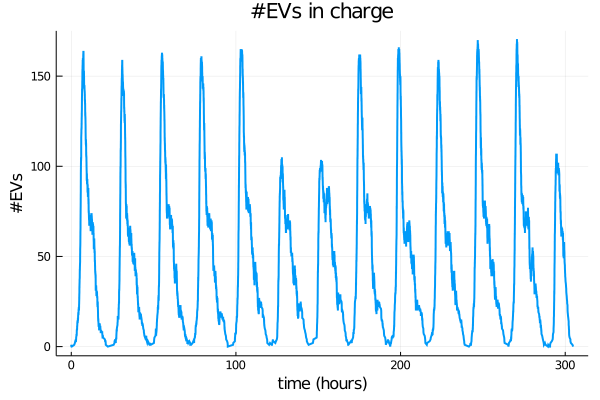

In [131]:
plot(time,n_EVs,lw=2, title="#EVs in charge", xlabel="time (hours)", ylabel="#EVs", legend=false)
#savefig("Real traces EVs.pdf")

In [139]:
plot(time,power,lw=2, title="Charging Power", xlabel="time (hours)", ylabel="Power (kW)", legend=false)
savefig("Real traces Power.pdf")